# PySpark Text Classification
#### MultiClass Text Classification
#### Task
+ predict the subject category given a course title or text

In [1]:
from pyspark import SparkContext

In [2]:
sc = SparkContext(master="local[2]")

In [3]:
# Launch UI
sc

<SparkContext master=local[2] appName=pyspark-shell>

In [4]:
# Create a spark session
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder.appName("TextClassifierwithPySpark").getOrCreate()

In [17]:
# Load our dataset
# inferSchema=True helps us to infer the schema from the test
df = spark.read.csv("data/udemy_courses_clean.csv", header=True, inferSchema=True)

In [10]:
df.show()

+---+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|_c0|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration| published_timestamp|         subject|  clean_course_title|
+---+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|  0|  1070968|Ultimate Investme...|https://www.udemy...|   True|  200|           2147|         23|          51|        All Levels|       1.5 hours|2017-01-18T20:58:58Z|Business Finance|Ultimate Investme...|
|  1|  1113822|Complete GST Cour...|https://www.udemy...|   True|   75|           2792|        923|         274|        All Levels|        39 hours|2017-03-09T16:34:20Z

In [11]:
df.columns

['_c0',
 'course_id',
 'course_title',
 'url',
 'is_paid',
 'price',
 'num_subscribers',
 'num_reviews',
 'num_lectures',
 'level',
 'content_duration',
 'published_timestamp',
 'subject',
 'clean_course_title']

In [18]:
# Select columns
df = df.select('course_title','subject')

In [19]:
df.show(5)

+--------------------+----------------+
|        course_title|         subject|
+--------------------+----------------+
|Ultimate Investme...|Business Finance|
|Complete GST Cour...|Business Finance|
|Financial Modelin...|Business Finance|
|Beginner to Pro -...|Business Finance|
|How To Maximize Y...|Business Finance|
+--------------------+----------------+
only showing top 5 rows



In [20]:
# Value counts
df.groupBy('subject').count().show()

+--------------------+-----+
|             subject|count|
+--------------------+-----+
|play Electric Gui...|    1|
|Multiply returns ...|    1|
|                null|    6|
|    Business Finance| 1198|
|Introduction Guit...|    1|
|Learn Play Fernan...|    1|
|      Graphic Design|  603|
|Aprende tocar el ...|    1|
|     Web Development| 1200|
|Learn Classical G...|    1|
| Musical Instruments|  676|
+--------------------+-----+



In [21]:
# Value counts via pandas
df.toPandas()['subject'].value_counts()

Web Development                                                                                                                                                                                              1200
Business Finance                                                                                                                                                                                             1198
Musical Instruments                                                                                                                                                                                           676
Graphic Design                                                                                                                                                                                                603
Learn Classical Guitar Technique play Spanish Romancehttpswwwudemycomguitartechniquestrue19513164643All Levels5 hours20131118T175959Z 265888Learn Guitar Worship

In [22]:
# Check for missing values
df.toPandas()['subject'].isnull().sum()

6

In [23]:
# Drop missing values
df = df.dropna(subset=['subject'])

In [24]:
# Check for missing values
df.toPandas()['subject'].isnull().sum()

0

In [25]:
df.show(5)

+--------------------+----------------+
|        course_title|         subject|
+--------------------+----------------+
|Ultimate Investme...|Business Finance|
|Complete GST Cour...|Business Finance|
|Financial Modelin...|Business Finance|
|Beginner to Pro -...|Business Finance|
|How To Maximize Y...|Business Finance|
+--------------------+----------------+
only showing top 5 rows



### Feature Extraction
#### Build Features From Text
+ CountVectorizer
+ TFIDF
+ WordEmbedding
+ HhashingTF
+ etc

In [26]:
# Load pkgs
import pyspark.ml.feature

In [27]:
# Show all I can do with it
dir(pyspark.ml.feature)

['Binarizer',
 'BucketedRandomProjectionLSH',
 'BucketedRandomProjectionLSHModel',
 'Bucketizer',
 'ChiSqSelector',
 'ChiSqSelectorModel',
 'CountVectorizer',
 'CountVectorizerModel',
 'DCT',
 'ElementwiseProduct',
 'FeatureHasher',
 'HasFeaturesCol',
 'HasHandleInvalid',
 'HasInputCol',
 'HasInputCols',
 'HasLabelCol',
 'HasMaxIter',
 'HasNumFeatures',
 'HasOutputCol',
 'HasOutputCols',
 'HasRelativeError',
 'HasSeed',
 'HasStepSize',
 'HasThreshold',
 'HasThresholds',
 'HashingTF',
 'IDF',
 'IDFModel',
 'Imputer',
 'ImputerModel',
 'IndexToString',
 'Interaction',
 'JavaEstimator',
 'JavaMLReadable',
 'JavaMLWritable',
 'JavaModel',
 'JavaParams',
 'JavaTransformer',
 'MaxAbsScaler',
 'MaxAbsScalerModel',
 'MinHashLSH',
 'MinHashLSHModel',
 'MinMaxScaler',
 'MinMaxScalerModel',
 'NGram',
 'Normalizer',
 'OneHotEncoder',
 'OneHotEncoderModel',
 'PCA',
 'PCAModel',
 'Param',
 'Params',
 'PolynomialExpansion',
 'QuantileDiscretizer',
 'RFormula',
 'RFormulaModel',
 'RegexTokenizer',
 'R

In [28]:
# Load our transfomer & extrator pkgs
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.feature import StringIndexer

In [29]:
df.show(5)

+--------------------+----------------+
|        course_title|         subject|
+--------------------+----------------+
|Ultimate Investme...|Business Finance|
|Complete GST Cour...|Business Finance|
|Financial Modelin...|Business Finance|
|Beginner to Pro -...|Business Finance|
|How To Maximize Y...|Business Finance|
+--------------------+----------------+
only showing top 5 rows



In [31]:
# Stages for the Pipeline
tokenizer = Tokenizer(inputCol='course_title',outputCol='mytokens')
stopwords_remover = StopWordsRemover(inputCol='mytokens', outputCol='filtered_tokens')
vectorizer = CountVectorizer(inputCol='filtered_tokens', outputCol='rawFeatures')
idf = IDF(inputCol='rawFeatures', outputCol='vectorizedFeatures')

In [32]:
# LabelEncoding/LabelIndexing
labelEncoder = StringIndexer(inputCol='subject',outputCol='label').fit(df)

In [33]:
labelEncoder.transform(df).show(5)

+--------------------+----------------+-----+
|        course_title|         subject|label|
+--------------------+----------------+-----+
|Ultimate Investme...|Business Finance|  1.0|
|Complete GST Cour...|Business Finance|  1.0|
|Financial Modelin...|Business Finance|  1.0|
|Beginner to Pro -...|Business Finance|  1.0|
|How To Maximize Y...|Business Finance|  1.0|
+--------------------+----------------+-----+
only showing top 5 rows



In [34]:
labelEncoder.labels

['Web Development',
 'Business Finance',
 'Musical Instruments',
 'Graphic Design',
 'Aprende tocar el Acorden de odo con tcnicahttpswwwudemycomaprendeatocarelacordeondeoidoycontecnicatrue25932134Beginner Level4 hours20140916T195145Z 263432Aprende los Secretos de la Armnica con HARPSOUL',
 'Introduction Guitar A Course Beginnershttpswwwudemycomintroductiontoguitartrue251631156Beginner Level25 hours20141030T155939Z 650804Guitar Master Class Learning Play Guitar Z',
 'Learn Classical Guitar Technique play Spanish Romancehttpswwwudemycomguitartechniquestrue19513164643All Levels5 hours20131118T175959Z 265888Learn Guitar Worship Learn 4 Songs unlock 1',
 'Learn Play Fernando Sors Study B minorhttpswwwudemycomstudyinbminortrue115140359Intermediate Level43 mins20140127T205816Z 398746Piano Chord Based System  Learn Play Pros Do',
 'Multiply returns Value Investinghttpswwwudemycommultiplyyourreturnsusingvalueinvestingtrue2019421963All Levels45 hours20150723T000833Z 874284Weekly Forex Analysis B

In [37]:
# Dict of labels
label_dict = {'Web Development':0.0,
 'Business Finance':1.0,
 'Musical Instruments':2.0,
 'Graphic Design':3.0}

In [41]:
df.show(5)

+--------------------+----------------+-----+
|        course_title|         subject|label|
+--------------------+----------------+-----+
|Ultimate Investme...|Business Finance|  1.0|
|Complete GST Cour...|Business Finance|  1.0|
|Financial Modelin...|Business Finance|  1.0|
|Beginner to Pro -...|Business Finance|  1.0|
|How To Maximize Y...|Business Finance|  1.0|
+--------------------+----------------+-----+
only showing top 5 rows



In [39]:
df = labelEncoder.transform(df)

In [40]:
df.show(5)

+--------------------+----------------+-----+
|        course_title|         subject|label|
+--------------------+----------------+-----+
|Ultimate Investme...|Business Finance|  1.0|
|Complete GST Cour...|Business Finance|  1.0|
|Financial Modelin...|Business Finance|  1.0|
|Beginner to Pro -...|Business Finance|  1.0|
|How To Maximize Y...|Business Finance|  1.0|
+--------------------+----------------+-----+
only showing top 5 rows



In [42]:
### Split Dataset
(trainDF, testDF) = df.randomSplit((0.7,0.3), seed=42)

In [43]:
trainDF.show()

+--------------------+--------------------+-----+
|        course_title|             subject|label|
+--------------------+--------------------+-----+
|#1 Piano Hand Coo...| Musical Instruments|  2.0|
|#10 Hand Coordina...| Musical Instruments|  2.0|
|#4 Piano Hand Coo...| Musical Instruments|  2.0|
|#5  Piano Hand Co...| Musical Instruments|  2.0|
|#6 Piano Hand Coo...| Musical Instruments|  2.0|
|'Geometry Of Chan...|    Business Finance|  1.0|
|              000!""|Learn Classical G...|  6.0|
|1 - Concepts of S...|    Business Finance|  1.0|
|          1 Hour CSS|     Web Development|  0.0|
|1. Principles of ...|    Business Finance|  1.0|
|10 Numbers Every ...|    Business Finance|  1.0|
|10.  Bonds and Bo...|    Business Finance|  1.0|
|101 Blues riffs -...| Musical Instruments|  2.0|
|15 Mandamientos p...|    Business Finance|  1.0|
|17 Complete JavaS...|     Web Development|  0.0|
|188% Profit in 1Y...|    Business Finance|  1.0|
|2 Easy Steps To I...|    Business Finance|  1.0|


In [45]:
### Estimator
from pyspark.ml.classification import LogisticRegression

In [46]:
lr = LogisticRegression(featuresCol='vectorizedFeatures', labelCol='label')

#### Building the Pipeline

In [47]:
from pyspark.ml import Pipeline

In [48]:
pipeline = Pipeline(stages=[tokenizer,stopwords_remover,vectorizer,idf,lr])

In [49]:
pipeline

Pipeline_96c194a6bad5

In [50]:
pipeline.stages

Param(parent='Pipeline_96c194a6bad5', name='stages', doc='a list of pipeline stages')

In [51]:
# Building Model
lr_model = pipeline.fit(trainDF)

In [52]:
lr_model

PipelineModel_7669e35843cf

In [53]:
# Predictions on our Test Dataset
predictions = lr_model.transform(testDF)

In [54]:
predictions.show()

+--------------------+-------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        course_title|            subject|label|            mytokens|     filtered_tokens|         rawFeatures|  vectorizedFeatures|       rawPrediction|         probability|prediction|
+--------------------+-------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|#12 Hand Coordina...|Musical Instruments|  2.0|[#12, hand, coord...|[#12, hand, coord...|(3670,[394,491,60...|(3670,[394,491,60...|[8.22575678848711...|[0.86083740537993...|       0.0|
|#7 Piano Hand Coo...|Musical Instruments|  2.0|[#7, piano, hand,...|[#7, piano, hand,...|(3670,[9,13,60,23...|(3670,[9,13,60,23...|[-1.5816511969932...|[6.40379189884028...|       2.0|
|'Greensleeves' Cr...|Musical Instruments|  2.0|['greensleeves', ...|[

In [55]:
# Select Columns
predictions.columns

['course_title',
 'subject',
 'label',
 'mytokens',
 'filtered_tokens',
 'rawFeatures',
 'vectorizedFeatures',
 'rawPrediction',
 'probability',
 'prediction']

In [57]:
predictions.select('rawPrediction','probability','subject','label','prediction').show(10)

+--------------------+--------------------+-------------------+-----+----------+
|       rawPrediction|         probability|            subject|label|prediction|
+--------------------+--------------------+-------------------+-----+----------+
|[8.22575678848711...|[0.86083740537993...|Musical Instruments|  2.0|       0.0|
|[-1.5816511969932...|[6.40379189884028...|Musical Instruments|  2.0|       2.0|
|[0.38747123627152...|[1.29430064459719...|Musical Instruments|  2.0|       2.0|
|[-2.0540053505170...|[3.67476794990401...|   Business Finance|  1.0|       1.0|
|[24.7266193282326...|[0.99999999908079...|    Web Development|  0.0|       0.0|
|[22.2213462251303...|[0.99999999175336...|    Web Development|  0.0|       0.0|
|[20.1005546377253...|[0.99999995838555...|    Web Development|  0.0|       0.0|
|[-5.9910327938439...|[2.64083766767662...|Musical Instruments|  2.0|       2.0|
|[-19.729920863364...|[4.16984026987555...|     Graphic Design|  3.0|       3.0|
|[-2.6725325296646...|[9.290

## Model Evaluation
+ Accuracy
+ Prediction
+ F1score
+ etc

In [58]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [59]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

In [60]:
accuracy = evaluator.evaluate(predictions)

In [61]:
accuracy

0.9163498098859315

In [63]:
#### Method 2: Precision. F1Score (Classification Report)
from pyspark.mllib.evaluation import MulticlassMetrics

In [65]:
lr_metric = MulticlassMetrics(predictions['label','prediction'].rdd) # convert to rdd

In [67]:
print("Accuracy:", lr_metric.accuracy)
print("Precision:", lr_metric.precision(1.0))
print("Recall:", lr_metric.recall(1.0))
print("F1Score:", lr_metric.fMeasure(1.0))

Accuracy: 0.9163498098859315
Precision: 0.9544159544159544
Recall: 0.8792650918635171
F1Score: 0.9153005464480874


## Confusion Matrix
+ convert to pandas
+ sklearn

In [68]:
y_true = predictions.select('label')
y_true = y_true.toPandas()
y_pred = predictions.select('prediction')
y_pred = y_pred.toPandas()

In [70]:
from sklearn.metrics import confusion_matrix, classification_report

In [71]:
cm = confusion_matrix(y_true, y_pred)

In [72]:
cm

array([[317,  14,   1,   4,   0,   0],
       [ 11, 335,   3,   2,   0,   0],
       [  8,  13, 156,   1,   0,   0],
       [  8,  17,   4, 156,   0,   0],
       [  0,   1,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0]])

In [77]:
import  matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion_matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalizer confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [78]:
label_dict.keys()

dict_keys(['Web Development', 'Business Finance', 'Musical Instruments', 'Graphic Design'])

In [75]:
class_names = ['Web Development', 'Business Finance', 'Musical Instruments', 'Graphic Design', 'N4', 'N5']

Confusion matrix, without normalization
[[317  14   1   4   0   0]
 [ 11 335   3   2   0   0]
 [  8  13 156   1   0   0]
 [  8  17   4 156   0   0]
 [  0   1   0   0   0   0]
 [  0   1   0   0   0   0]]


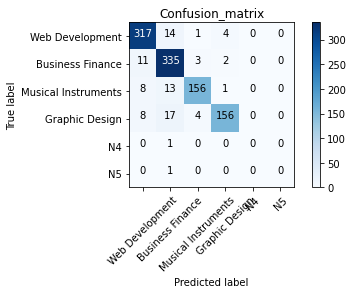

In [79]:
plot_confusion_matrix(cm, class_names)

In [83]:
# It hides the error message
import warnings
warnings.filterwarnings('ignore')

In [84]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

                     precision    recall  f1-score   support

    Web Development       0.92      0.94      0.93       336
   Business Finance       0.88      0.95      0.92       351
Musical Instruments       0.95      0.88      0.91       178
     Graphic Design       0.96      0.84      0.90       185
                 N4       0.00      0.00      0.00         1
                 N5       0.00      0.00      0.00         1

           accuracy                           0.92      1052
          macro avg       0.62      0.60      0.61      1052
       weighted avg       0.92      0.92      0.92      1052



### Making Single Prediction
+ sample as DF
+ apply pipeline

In [85]:
from pyspark.sql.types import StringType

In [87]:
ex1 = spark.createDataFrame([
    ("Building Machine Learning Apps with Python and PySpark", StringType())
],
# Column Name
["course_title"]
)

In [88]:
ex1.show()

+--------------------+---+
|        course_title| _2|
+--------------------+---+
|Building Machine ...| {}|
+--------------------+---+



In [89]:
# Show full
ex1.show(truncate=False)

+------------------------------------------------------+---+
|course_title                                          |_2 |
+------------------------------------------------------+---+
|Building Machine Learning Apps with Python and PySpark|{} |
+------------------------------------------------------+---+



In [90]:
# Predict
pred_ex1 = lr_model.transform(ex1)

In [91]:
pred_ex1.show()

+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        course_title| _2|            mytokens|     filtered_tokens|         rawFeatures|  vectorizedFeatures|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Building Machine ...| {}|[building, machin...|[building, machin...|(3670,[57,79,115,...|(3670,[57,79,115,...|[14.6893212262791...|[0.99999805300087...|       0.0|
+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+



In [92]:
pred_ex1.columns

['course_title',
 '_2',
 'mytokens',
 'filtered_tokens',
 'rawFeatures',
 'vectorizedFeatures',
 'rawPrediction',
 'probability',
 'prediction']

In [93]:
pred_ex1.select('course_title','rawPrediction','probability','prediction').show()

+--------------------+--------------------+--------------------+----------+
|        course_title|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|Building Machine ...|[14.6893212262791...|[0.99999805300087...|       0.0|
+--------------------+--------------------+--------------------+----------+



In [94]:
label_dict

{'Web Development': 0.0,
 'Business Finance': 1.0,
 'Musical Instruments': 2.0,
 'Graphic Design': 3.0}